# Introduction


                                    Matthew Inglis-Whalen (Tasty Bytes Data Science Team Member)
                                                                                                   August 2023

Dear Head of Data Science,

I've prepared this notebook to serve as a report on my findings. As you might recall, the Product Team wants us to better understand which recipes are the most popular. Popular recipes posted on the homepage drive traffic to our site, increasing subscription uptake for our paid services.

I'll be taking a look at the data that's been sent over from the product team. As a quick summary of the analysis, the data was a little messy, with some missing values, so I needed to perform some cleanup and imputation. Exploring the data showed that vegetables were the most popular recipe type (with 99% of those recipes having a high traffic volume), while beverages were the least popular. Higher calories and protein content were associated with lower popularities, in contrast to the finding that a higher sugar content is correlated with a higher popularity. 

I looked at two models, a simple Logistic Regression and a Random Forest Classifier, and decided that the **Random Forest** worked the best for predicting popularity. This model worked best in terms of the minimizing the number of low-traffic recipes that are predicted by the model to be high-traffic, which should help us know with more than **99%** certainty that a chosen recipe will drive traffic to the website.

Our goal has been achieved, so we can send the model over to the Product Team for use in production.

In [1]:
# base packages
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style('darkgrid')
sns.set_palette('colorblind')

# data validation 
import missingno as miss

# preprocessing
from sklearn.utils import shuffle

# train/test systems
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, classification_report, confusion_matrix, plot_roc_curve
from sklearn.inspection import permutation_importance

# timing
from time import perf_counter

# machine learning classifier models to try
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
def get_binxs_props_sigmas(df, col_name) :
    """ Get bin position, the proportion of high traffic in that bin, and the associated standard error"""

    bins = np.linspace(np.min(df[col_name]),np.max(df[col_name]),10,endpoint=True)
    bin_mids = []
    props = []
    errs = []

    for bin_low, bin_high in zip(bins[:-1],bins[1:]) :
        
        mask = (bin_low <= df[col_name]) & (df[col_name] < bin_high)
        tmp_prop = df[mask]['high_traffic'].mean()  # the proportions
        tmp_count = len(df[mask])                   # count all in the bin. For error bars

        bin_mids.append( (bin_low+bin_high)/2 )
        props.append(tmp_prop)
        
         # from usual binomial variance V_count = np(1-p), sigma_count = sqrt(np(1-p)) so sigma prop = sqrt(p(1-p)/n)
        errs.append( (np.sqrt(tmp_prop*(1-tmp_prop)/(tmp_count-1) ) if tmp_count>1 else 0.5 if tmp_prop > 0.5 else 0,
                      np.sqrt(tmp_prop*(1-tmp_prop)/(tmp_count-1) ) if tmp_count>1 else 0.5 if tmp_prop < 0.5 else 0) ) 
                      # also correct for fact you can't estimate variance from a single data point
            
    for idx, prop in enumerate(props) :
        if np.isnan(prop):
            props[idx] = np.nanmean(props)
        
    return bin_mids, props, np.transpose(errs)

In [3]:
def undummify(df, prefix_sep="_"):
    '''Undo the pd.get_dummies() routine'''
    cols2collapse = {
        item.split(prefix_sep)[0]: (prefix_sep in item) for item in df.columns
    }
    series_list = []
    for col, needs_to_collapse in cols2collapse.items():
        if needs_to_collapse:
            undummified = (
                df.filter(like=col)
                .idxmax(axis=1)
                .apply(lambda x: x.split(prefix_sep, maxsplit=1)[1])
                .rename(col)
            )
            series_list.append(undummified)
        else:
            series_list.append(df[col])
    undummified_df = pd.concat(series_list, axis=1)
    return undummified_df

# Data Validation

- Import data
- Check missingness
- Clean outstanding issues

## Broad Overview

Here's the dataset:

In [4]:
# load and inspect the data
recipe_raw = pd.read_csv('recipe_site_traffic_2212.csv')
recipe_raw

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN
...,...,...,...,...,...,...,...,...
942,943,1161.00,5.31,22.39,44.22,Lunch/Snacks,2,NaN
943,944,NaN,NaN,NaN,NaN,Potato,2,High
944,945,951.74,29.42,3.57,13.87,Pork,2,High
945,946,266.61,35.77,0.97,8.07,Potato,6,High


I'll first try to get a broad overview of the dataset's missing values. Below I've printed out the number of missing entries in each column and plotted the missingness by row and column, with missing entries shown in white. 

Column-by-column, it first appears there is no missingness in the `recipe` column. 

Next, it appears there is a non-negligable amount of missingness amongst the nutritional information columns (calories, carbs, sugar, protein). There, 5.5% of rows are missing (52 / 947 total rows). This percentage is a little too high to simply drop these rows for training, and moreover it also appears that the nutritional information is missing not-at-random, i.e. the missingness is correlated between columns. 

The next two columns (category and servings) have no missing values.

Finally, it appears that there is a significant amount of missingness (373/947 ~ 39%) in the target label column `high_traffic`.

recipe            0
calories         52
carbohydrate     52
sugar            52
protein          52
category          0
servings          0
high_traffic    373
dtype: int64


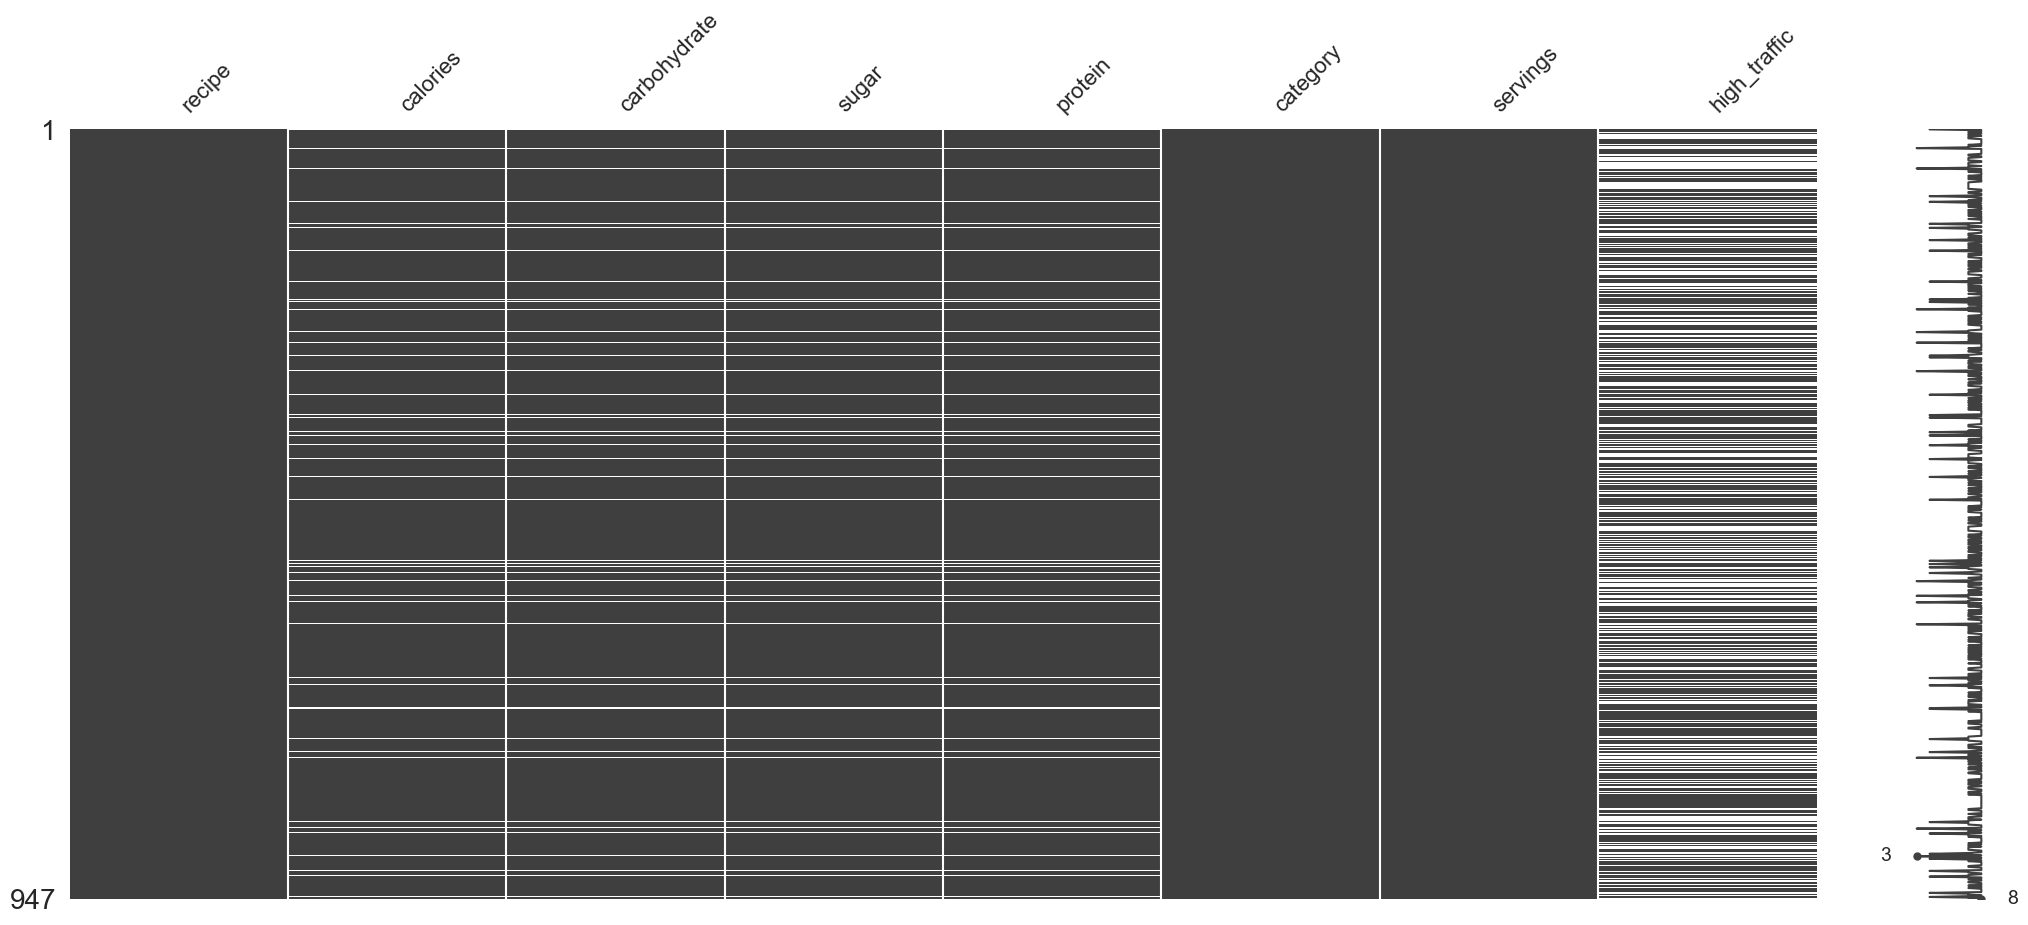

In [5]:
# missingness
print(recipe_raw.isna().sum())
miss.matrix(recipe_raw)  # no missingness in category nor servings
plt.savefig('missing.png')
plt.show()

## Detailed Cleaning

I'll now go into more detailed cleaning for each of these columns. First checking the 'recipe' column, which acts as a unique identifier for each entry, I see that there are no duplicates, and no missing values.

In [6]:
# check for duplicated ids
print(f"Num missing: {recipe_raw['recipe'].isna().sum()}")
print(f"Num duplicated: {recipe_raw['recipe'].duplicated().sum()}")
print(f"Num unique: {recipe_raw['recipe'].nunique()} vs total number of rows {len(recipe_raw['recipe'])}")

Num missing: 0
Num duplicated: 0
Num unique: 947 vs total number of rows 947


Next is the nutritional information. We know there is 52 missing entries in each of these columns, and we see in the correlation heatmap below that the missingness is 100% correlated amongst each of the 4 columns.

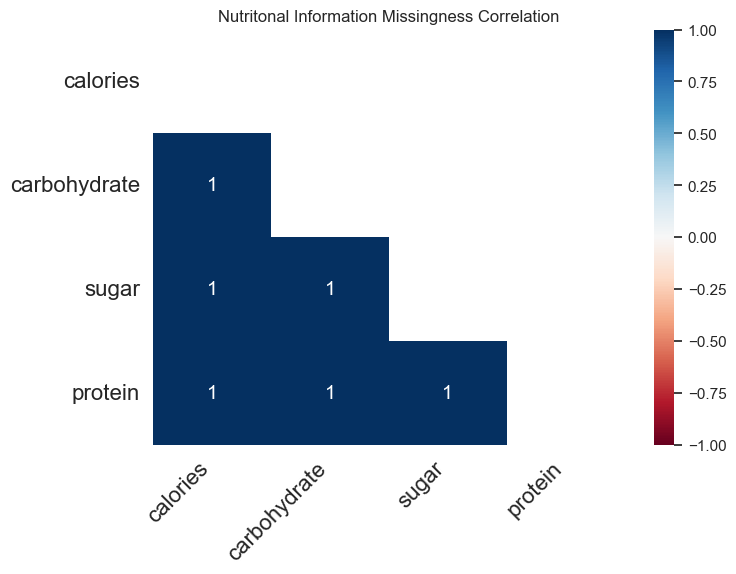

In [7]:
fig, ax = plt.subplots()
miss.heatmap(recipe_raw[['calories','carbohydrate','sugar','protein']], ax=ax)
fig.tight_layout(rect=[0,0,1.2,1.2])  # so the image isn't gigantic
plt.title('Nutritonal Information Missingness Correlation')
plt.savefig('miss_corr.png')
plt.show()

Predicting a recipe's nutritional information isn't important to this project, so these columns will simply be median-filled. But what **is** important are reasons that a recipe might be popular/unpopular. Since the missingness between nutritional columns is 100% correlated, it is unlikely that their missingnesss is due to data collections issues, and most likely represents the actual state of the recipe. Since this information might be important, I'll make note of these recipes without nutritional information by creating a new feature column called `nonutri`.

In [8]:
recipe_raw['nonutri'] = recipe_raw['calories'].isna().astype(int)

mean_replacements = {
    'calories'     : recipe_raw['calories'].median(),
    'carbohydrate' : recipe_raw['carbohydrate'].median(),
    'sugar'        : recipe_raw['sugar'].median(),
    'protein'      : recipe_raw['protein'].median()
}
recipe_raw.fillna(value=mean_replacements, inplace=True)

Next is the `category` column. There are no missing values and the dtype is correct, but there is one category `Chicken Breast` that wasn't included in the dataset description. Since it's my job to ensure that the cleaned dataset conforms precisely with the provided manifest, I'll merge the `Chicken Breast` category into the `Chicken` category.

In [9]:
print(f"Num missing: {recipe_raw['category'].isna().sum()}")
print(f"category dtype: {recipe_raw['category'].dtypes}")
print(f"{len(recipe_raw['category'].unique())} categories: {recipe_raw['category'].unique()}")

recipe_raw['category'] = recipe_raw['category'].str.replace(' Breast','')
recipe_raw['category'].describe()

Num missing: 0
category dtype: object
11 categories: ['Pork' 'Potato' 'Breakfast' 'Beverages' 'One Dish Meal' 'Chicken Breast'
 'Lunch/Snacks' 'Chicken' 'Vegetable' 'Meat' 'Dessert']


count         947
unique         10
top       Chicken
freq          172
Name: category, dtype: object

Now looking at the `servings` column, we see that there are no missing values, but the dtype is wrong. 3 of the entries have the string ' as a snack' appended to the numerical serving size. We can also see that these 3 are also in the `Lunch/Snacks` category, so the 'as a snack' string is redundant information, and should simply be removed

In [10]:
print(f"category dtype: {recipe_raw['servings'].dtypes}\n")  # for some reason the servings isn't an int64 dtype
print(recipe_raw['servings'].value_counts())  # Oh, because some (3 of them) have 'as a snack' added to serving size

# let's look at these in detail
mask = recipe_raw['servings'].str.get(-1) == 'k'
recipe_raw[mask]

category dtype: object

4               389
6               197
2               183
1               175
4 as a snack      2
6 as a snack      1
Name: servings, dtype: int64


,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic,nonutri
451,452,1542.53,14.73,5.71,29.92,Lunch/Snacks,4 as a snack,High,0
548,549,1440.69,30.59,5.78,30.63,Lunch/Snacks,6 as a snack,High,0
735,736,513.75,65.87,18.63,18.39,Lunch/Snacks,4 as a snack,NaN,0


In [11]:
# we see they're already labeled as snacks, so we'll just cull off that extra part of the servings string
recipe_raw['servings'] = recipe_raw['servings'].str.get(0).astype(int)

print(f"\nNum missing: {recipe_raw['servings'].isna().sum()}")
print(f"servings dtype: {recipe_raw['servings'].dtypes}")
print(f"{len(recipe_raw['servings'].unique())} categories: {recipe_raw['servings'].unique()}")


Num missing: 0
servings dtype: int64
4 categories: [6 4 1 2]


Finally, looking at the target column `high_traffic`, we see that `high_traffic` seems to be encoded as "High"/null, so it's not actually "missing". Since the cleaned data should exactly meet the requirement of the provided dataset description, and since the description says that this column should be a character string, I'll code the low-traffic (null-coded) values as the string "Low" 

In [12]:
print(f"Num missing: {recipe_raw['high_traffic'].isna().sum()}")
print(f"high_traffic dtype: {recipe_raw['high_traffic'].dtypes}")
print(f"{len(recipe_raw['high_traffic'].unique())} categories: {recipe_raw['high_traffic'].unique()}")
print(recipe_raw['high_traffic'].value_counts(dropna=False))

# the target category column 'high_traffic' seems to be encoded as 'High'/null, so it's not actually "missing"

recipe_raw['high_traffic'] = recipe_raw['high_traffic'].map(lambda s: "High" if s == "High" else "Low" )
print(recipe_raw['high_traffic'].value_counts())

Num missing: 373
high_traffic dtype: object
2 categories: ['High' nan]
High    574
NaN     373
Name: high_traffic, dtype: int64
High    574
Low     373
Name: high_traffic, dtype: int64


In [13]:
recipe_raw.describe()

,recipe,calories,carbohydrate,sugar,protein,servings,nonutri
count,947.000000,947.000000,947.000000,947.000000,947.000000,947.000000,947.000000
mean,474.000000,427.846019,34.323464,8.799641,23.416283,3.477297,0.054910
std,273.519652,441.673556,42.836191,14.306785,35.486699,1.732741,0.227925
min,1.000000,0.140000,0.030000,0.010000,0.000000,1.000000,0.000000
25%,237.500000,114.410000,9.135000,1.795000,3.465000,2.000000,0.000000
50%,474.000000,288.550000,21.480000,4.550000,10.800000,4.000000,0.000000
75%,710.500000,576.225000,42.590000,9.285000,28.530000,4.000000,0.000000
max,947.000000,3633.160000,530.420000,148.750000,363.360000,6.000000,1.000000


## Summary

There were 947 rows and 8 columns. Description of the dataset after cleaning:

 - 1 ≤ `recipe` ≤ 947 -- unique id of the recipe. No missing values, same as described in the instructions. No cleaning needed. 
 - 0.14 ≤ `calories` ≤ 3633.16 -- numeric, as described, but with 52 missing values that were filled with the column's median value.
 - 0.03 ≤ `carbohydrate` ≤ 530.42 -- numeric, as described, but with 52 missing values that were filled with the column's median value.
 - 0.01 ≤ `sugar` ≤ 148.75 -- numeric, as described, but with 52 missing values that were filled with the column's median value.
 - 0.00 ≤ `protein` ≤ 363.36 -- numeric, as described, but with 52 missing values that were filled with the column's median value.
 - `category` ∈ \['Lunch/Snacks', 'Beverages', 'Potato', 'Vegetable', 'Meat', 'Chicken, 'Pork', 'Dessert', 'Breakfast', 'One Dish Meal'\] -- character string, no missing values. Not exactly as described, since there were 11 categories in the dataset instead of 10. 'Chicken Breast' appeared as a category but did not appear in the dataset description, so these entries were instead placed into the 'Chicken' category.
- `servings` ∈ \[1,2,4,6\] -- numeric, no missing values. Not exactly as descibed since 3 entries had the string " as a snack" appended. These were stripped off to simply leave the numeric value.
- `high_traffic` ∈ \['High','Low'\] -- character string. The high-traffic values were -- as described -- coded as 'High', but the low-traffic values were not as described since they were not coded as a character string. Instead, they were coded as missing values (technically the string "NA" which pandas interprets as missing). So there were 373 missing values, which simply represented the low-traffic values, and these were re-coded as the string 'Low'.

In addition to these 8 columns, I have also added one column `nonutri` which keeps track of when no nutritional information was provided in the recipe.

# Exploration of Data

- Single-variable plots
- Multi-variable plots

In [14]:
# first turn the high_traffic into a one-hot encoded column
recipe_raw['high_traffic'] = recipe_raw['high_traffic'].map(lambda s: 1 if s=='High' else 0)
recipe_raw

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic,nonutri
0,1,288.55,21.48,4.55,10.80,Pork,6,1,1
1,2,35.48,38.56,0.66,0.92,Potato,4,1,0
2,3,914.28,42.68,3.09,2.88,Breakfast,1,0,0
3,4,97.03,30.56,38.63,0.02,Beverages,4,1,0
4,5,27.05,1.85,0.80,0.53,Beverages,4,0,0
...,...,...,...,...,...,...,...,...,...
942,943,1161.00,5.31,22.39,44.22,Lunch/Snacks,2,0,0
943,944,288.55,21.48,4.55,10.80,Potato,2,1,1
944,945,951.74,29.42,3.57,13.87,Pork,2,1,0
945,946,266.61,35.77,0.97,8.07,Potato,6,1,0


## Feature Distributions

### How many recipes are popular?

A simple question. Our recipes seem to do pretty well on average, with about 60% of our recipes generating high traffic

Proportion high traffic: 0.606


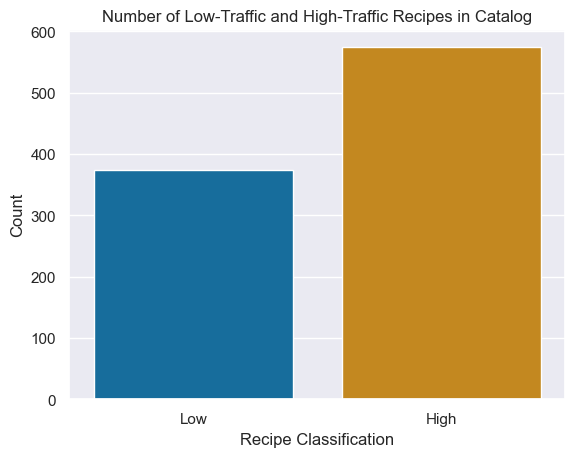

In [15]:
print(f"Proportion high traffic: {recipe_raw['high_traffic'].sum()/len(recipe_raw['high_traffic']):.3F}")
fig, ax = plt.subplots()
sns.countplot(data=recipe_raw, x='high_traffic', ax=ax).set(xticklabels=["Low", "High"])
ax.set_title("Number of Low-Traffic and High-Traffic Recipes in Catalog")
ax.set_ylabel("Count")
ax.set_xlabel("Recipe Classification")
plt.savefig("high_traffic_counts.png")
plt.show()

### Nutrional information -- Calories, Carbs, Sugar, Protein

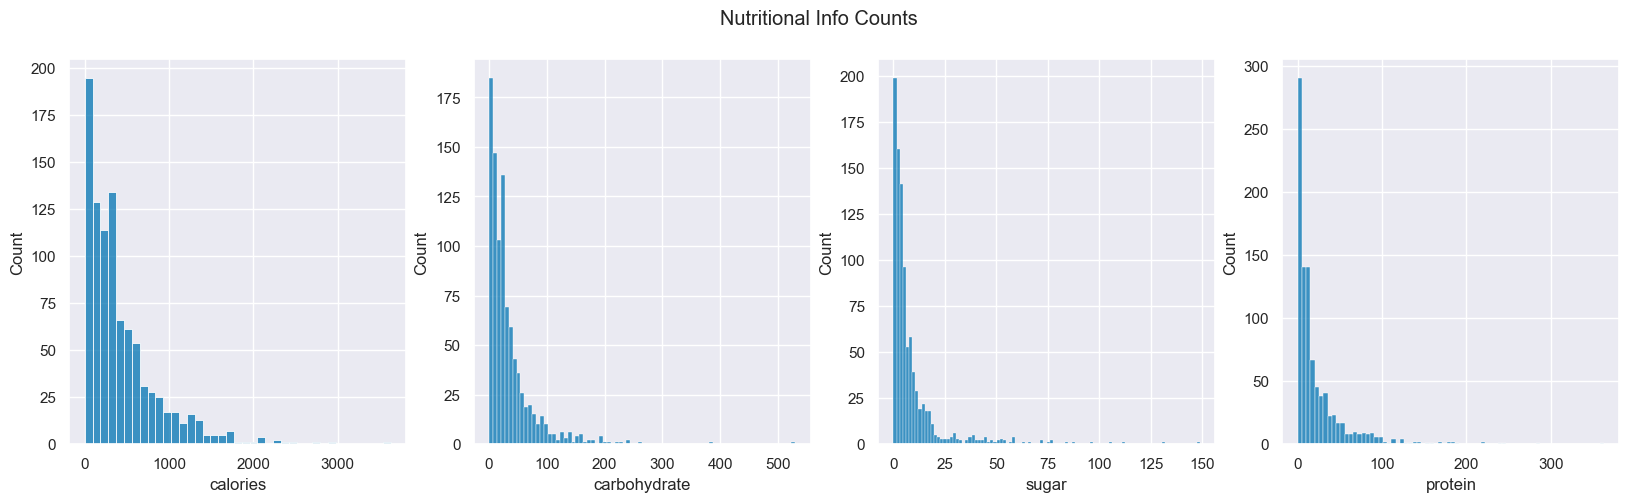

In [16]:
fig, axes = plt.subplots(1,4,figsize=(20,5))
sns.histplot(data=recipe_raw, x='calories', ax=axes[0])
sns.histplot(data=recipe_raw, x='carbohydrate', ax=axes[1])
sns.histplot(data=recipe_raw, x='sugar', ax=axes[2])
sns.histplot(data=recipe_raw, x='protein', ax=axes[3])
fig.suptitle('Nutritional Info Counts')
plt.savefig('nutrition_histo.png')
plt.show()

The nutrional information looks like it's exponentially distributed. I'll take the log of each to try to make the transformed quantity normally distriuted.

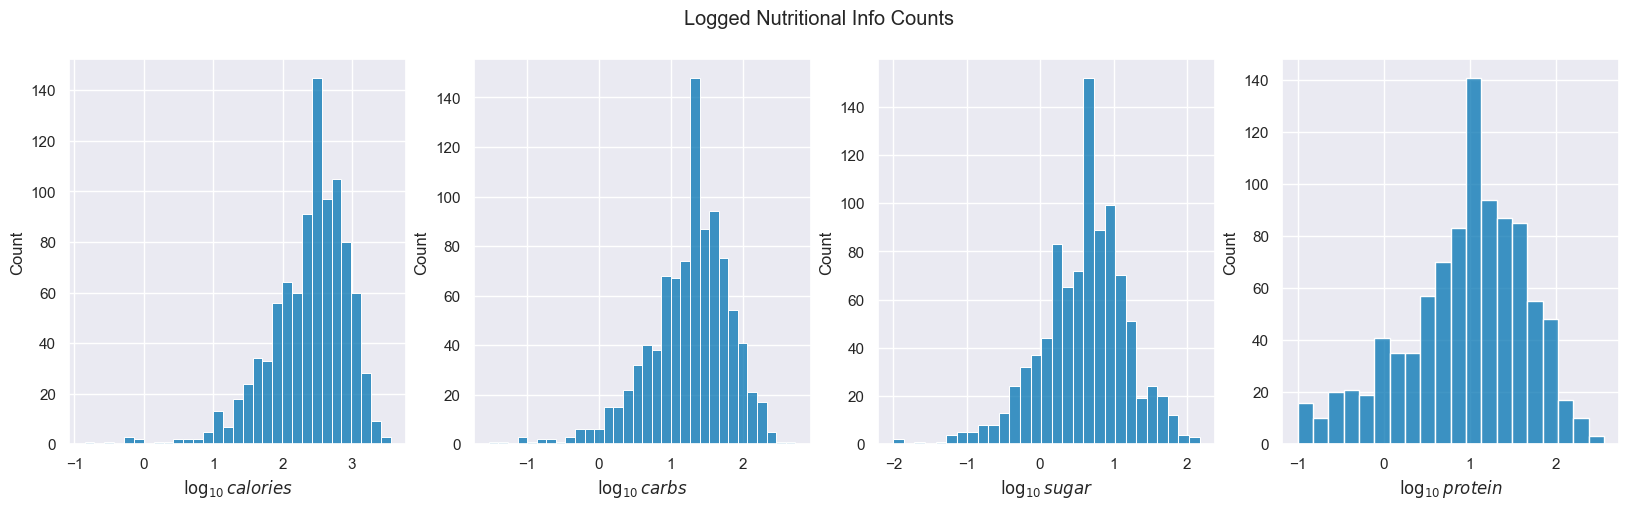

In [17]:
recipe_raw['L_cal'] = recipe_raw['calories'].map(np.log10)
recipe_raw['L_carb'] = recipe_raw['carbohydrate'].map(np.log10)
recipe_raw['L_sug'] = recipe_raw['sugar'].map(np.log10)
recipe_raw['L_prot'] = (recipe_raw['protein']+0.1).map(np.log10) 
# the protein column needs a small offset (0.1) to ensure the 0-protein values can also be transformed 

fig, axes = plt.subplots(1,4,figsize=(20,5))
sns.histplot(data=recipe_raw, x='L_cal', ax=axes[0]).set_xlabel("$\log_{10} calories$")
sns.histplot(data=recipe_raw, x='L_carb', ax=axes[1]).set_xlabel("$\log_{10} carbs$")
sns.histplot(data=recipe_raw, x='L_sug', ax=axes[2]).set_xlabel("$\log_{10} sugar$")
sns.histplot(data=recipe_raw, x='L_prot', ax=axes[3]).set_xlabel("$\log_{10} protein$")
fig.suptitle('Logged Nutritional Info Counts')
plt.savefig('log_nutrition_histo.png')
plt.show()

These are all skewed a little left, but it's still better than before

### Number of Servings

There are more 4-serving recipes in the dataset than 1-, 2-, or 6-serving recipes.

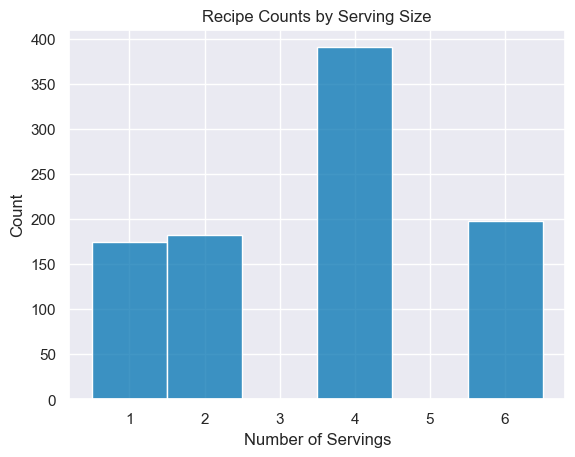

In [18]:
fig, ax = plt.subplots()
sns.histplot(data=recipe_raw, x='servings',bins=[i+0.5 for i in range(7)],ax=ax)
ax.set_title("Recipe Counts by Serving Size")
ax.set_xlabel("Number of Servings")
plt.savefig('serving_counts.png')
plt.show()

### Category

There is mostly an equal distribution of recipe categories in the dataset, except for the `Chicken` category which has roughly twice as many entries. This is because I merged the `Chicken Breast` category into the `Chicken` category.

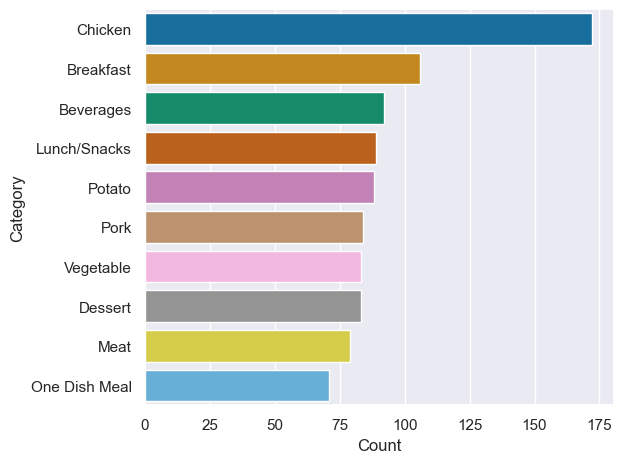

In [19]:
# how many recipes are there by category?
fig, ax = plt.subplots()
sns.countplot(data=recipe_raw, y='category',ax=ax, order=recipe_raw['category'].value_counts().index )
ax.set(ylabel='Category', xlabel='Count')
plt.tight_layout()
plt.savefig('category_counts.png')
plt.show()

## Popularity

### Popularity by Recipe ID

If a recipe's ID is assigned sequentially at the time the recipe is uploaded to the website, then the recipe ID could be an alias for time. It is possible that, due to factors like recipe quality, recipes are becoming more or less popular over time. I'll investigate this by binning the recipes by their ID number, and seeing if there exists some overall trend.

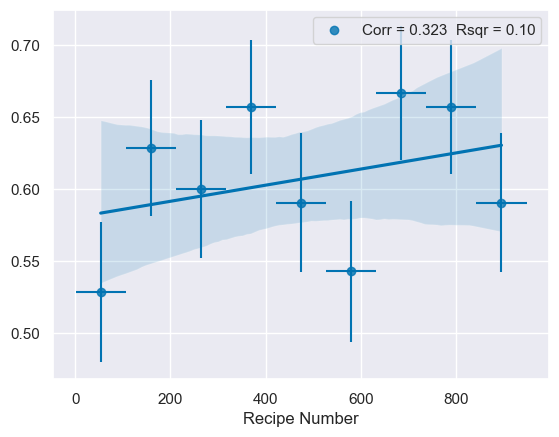

In [20]:
bins_rec,  props_rec,  errs_rec  = get_binxs_props_sigmas(recipe_raw,'recipe')
corr_coef_rec = np.corrcoef(bins_rec, props_rec)[0,1]
fig, ax = plt.subplots()
sns.regplot(x=bins_rec,y=props_rec, ax=ax, label=f"Corr = {corr_coef_rec:.3F}  Rsqr = {corr_coef_rec**2:.2F}").set(xlabel="Recipe Number")
ax.errorbar(x=bins_rec, y=props_rec, yerr=errs_rec, xerr=(bins_rec[1]-bins_rec[0])/2, ecolor=sns.color_palette()[0],ls='None' )
ax.legend()
plt.show()

However, it appears that there is no statistically significant trend upwards or downwards in popularity based on recipe ID.

### Popularity by Category

I've looked at how popular each category of recipe is, based on the proportion of popular recipes (high-traffic recipes / total recipes) for that category.

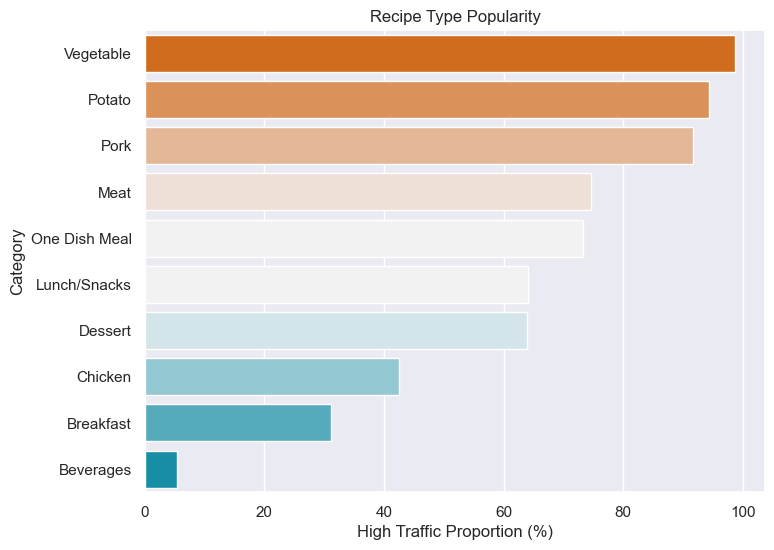

In [21]:
# investigate average popularity by category
popularity_by_category = pd.DataFrame( recipe_raw.groupby('category', as_index=False)['high_traffic'].mean() )
popularity_by_category['prop'] = popularity_by_category['high_traffic']*100
popularity_by_category.sort_values('prop',ascending=False,inplace=True)

colors = sns.diverging_palette(h_neg=220, h_pos=25, s=100, l=60, sep=60, n=len(popularity_by_category['category'].unique()))
color_dict = { cat: color for cat, color in zip(reversed(popularity_by_category['category'].values),colors) }

fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(data=popularity_by_category,x='prop',y='category', palette=color_dict, ax=ax)
ax.set_title('Recipe Type Popularity')
ax.set_xlabel('High Traffic Proportion (%)')
ax.set_ylabel('Category')
plt.savefig('CategoryPopularity.png')
plt.show()

In [22]:
print(popularity_by_category)

        category  high_traffic       prop
9      Vegetable      0.987952  98.795181
8         Potato      0.943182  94.318182
7           Pork      0.916667  91.666667
5           Meat      0.746835  74.683544
6  One Dish Meal      0.732394  73.239437
4   Lunch/Snacks      0.640449  64.044944
3        Dessert      0.638554  63.855422
2        Chicken      0.424419  42.441860
1      Breakfast      0.311321  31.132075
0      Beverages      0.054348   5.434783


Our cutoff for a 'job well-done' is achieving a precision of >80%. The top 3 categories -- Vegatable, Potato, and Pork -- exceed this threshold, so one successful strategy might be to only and always choose recipes from this group of three. 

I'll also note that the popularity decreases towards the front of the alphabet, but that's a story for another time...

### Popularity by Serving Count

There seems to be no strong preference for serving count

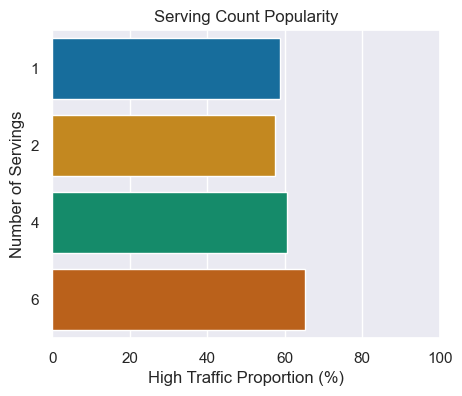

In [23]:
popularity_by_servings = pd.DataFrame( recipe_raw.groupby('servings', as_index=False)['high_traffic'].mean() )
popularity_by_servings['prop'] = popularity_by_servings['high_traffic']*100


fig, ax = plt.subplots(figsize=(5,4))
sns.barplot(data=popularity_by_servings,x='prop',y='servings', ax=ax, orient='h')
ax.set_title('Serving Count Popularity')
ax.set_xlabel('High Traffic Proportion (%)')
ax.set_ylabel('Number of Servings')
plt.xlim([0,100])
plt.savefig('ServingsPopularity.png')
plt.show()

### Popularity by NoNutri

There seems to be a slight preference for nutritional information not being included in the recipe.

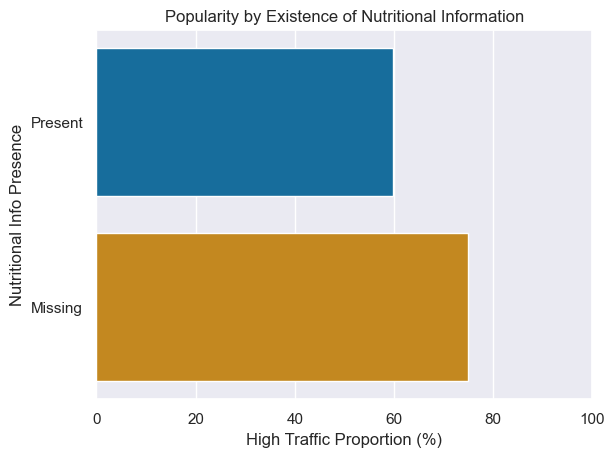

In [24]:
popularity_by_servings = pd.DataFrame( recipe_raw.groupby('nonutri', as_index=False)['high_traffic'].mean() )
popularity_by_servings['prop'] = popularity_by_servings['high_traffic']*100


fig, ax = plt.subplots()
g = sns.barplot(data=popularity_by_servings,x='prop',y='nonutri', ax=ax, orient='h')
g.set(yticklabels=['Present','Missing'])
ax.set_title('Popularity by Existence of Nutritional Information')
ax.set_xlabel('High Traffic Proportion (%)')
ax.set_ylabel('Nutritional Info Presence')
plt.xlim([0,100])
plt.savefig('NoNutriPopularity.png')
plt.show()

### Popularity by Nutritional Information

By binning the logged nutritional information and counting the proportion of high-traffic recipes in that bin, I can investigate how the various nutritional data affects the popularity. There appears to be a positive correlation between calories and popularity. The same positive trend is seen with protein. A slight negative correlation is observed with sugar, while no definitive correlation is seen with carbs.

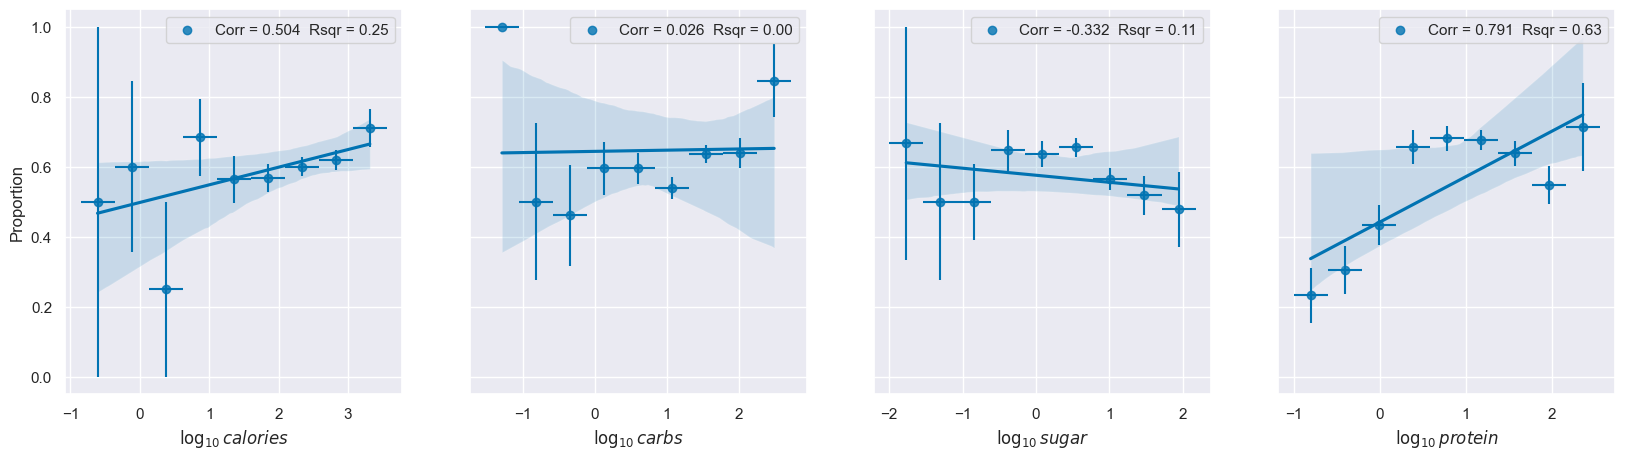

In [25]:
bins_cal,  props_cal,  errs_cal = get_binxs_props_sigmas(recipe_raw,'L_cal')
bins_carb, props_carb, errs_carb = get_binxs_props_sigmas(recipe_raw,'L_carb')
bins_sug,  props_sug,  errs_sug  = get_binxs_props_sigmas(recipe_raw,'L_sug')
bins_prot, props_prot, errs_prot = get_binxs_props_sigmas(recipe_raw,'L_prot')

fig, axes = plt.subplots(1,4,figsize=(20,5),sharey=True)

corr_coef_cal = np.corrcoef(bins_cal, props_cal)[0,1]
sns.regplot(x=bins_cal,y=props_cal, ax=axes[0], label=f"Corr = {corr_coef_cal:.3F}  Rsqr = {corr_coef_cal**2:.2F}").set(xlabel="$\log_{10} calories$")
axes[0].errorbar(x=bins_cal, y=props_cal, yerr=errs_cal, xerr=(bins_cal[1]-bins_cal[0])/2, ecolor=sns.color_palette()[0],ls='None' )
axes[0].legend()

corr_coef_carb = np.corrcoef(bins_carb, props_carb)[0,1]
sns.regplot(x=bins_carb,y=props_carb, ax=axes[1], label=f"Corr = {corr_coef_carb:.3F}  Rsqr = {corr_coef_carb**2:.2F}").set(xlabel="$\log_{10} carbs$")
axes[1].errorbar(x=bins_carb, y=props_carb, yerr=errs_carb, xerr=(bins_carb[1]-bins_carb[0])/2, ecolor=sns.color_palette()[0],ls='None' )
axes[1].legend()

corr_coef_sug = np.corrcoef(bins_sug, props_sug)[0,1]
sns.regplot(x=bins_sug,y=props_sug, ax=axes[2], label=f"Corr = {corr_coef_sug:.3F}  Rsqr = {corr_coef_sug**2:.2F}").set(xlabel="$\log_{10} sugar$")
axes[2].errorbar(x=bins_sug, y=props_sug, yerr=errs_sug, xerr=(bins_sug[1]-bins_sug[0])/2, ecolor=sns.color_palette()[0],ls='None' )
axes[2].legend()

corr_coef_prot = np.corrcoef(bins_prot, props_prot)[0,1]
sns.regplot(x=bins_prot,y=props_prot, ax=axes[3], label=f"Corr = {corr_coef_prot:.3F}  Rsqr = {corr_coef_prot**2:.2F}").set(xlabel="$\log_{10} protein$")
axes[3].errorbar(x=bins_prot, y=props_prot, yerr=errs_prot, xerr=(bins_prot[1]-bins_prot[0])/2, ecolor=sns.color_palette()[0],ls='None' )
axes[3].legend()

axes[0].set_ylabel("Proportion")
plt.savefig('nutrition_popularity.png')
plt.show()

I can try to take advantage of these trends by a quick attempt at dimensional reduction: summing the positive trending variables and subtracting the negatively trending variables, the 'super variable' might be good at disambiguating popular from the non-popular recipes

I'll define

super = L_cal + L_prot - L_sug

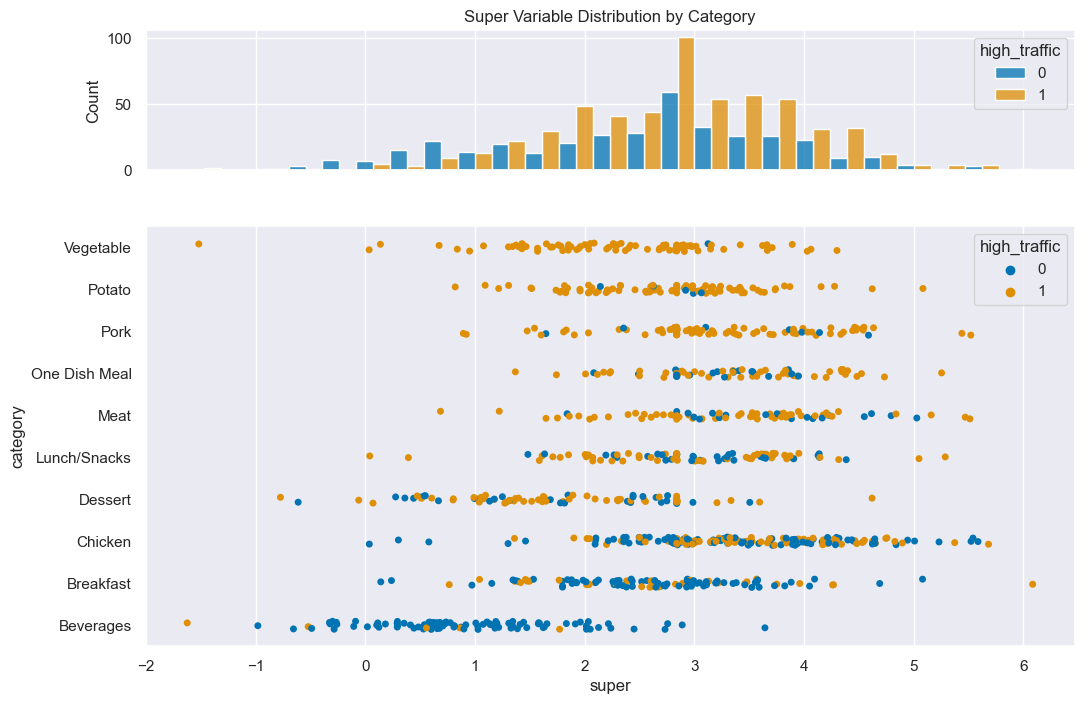

In [26]:
# try to construct a 'super variable' based on the observed trends
order=['Beverages', 'Breakfast', 'Chicken',
       'Dessert', 'Lunch/Snacks', 'Meat', 'One Dish Meal', 'Pork', 'Potato', 'Vegetable']
rev_order = ['Vegetable','Potato','Pork','One Dish Meal',
             'Meat','Lunch/Snacks','Dessert','Chicken','Breakfast','Beverages']
recipe_raw['super'] = recipe_raw['L_cal'] + recipe_raw['L_prot'] - recipe_raw['L_sug']
fig, axes = plt.subplots(2,1,figsize=(12,8),sharex=True, gridspec_kw={'height_ratios': [1, 3]})
sns.histplot(data=recipe_raw,x='super',hue='high_traffic',multiple='dodge', ax=axes[0]).set(title='Super Variable Distribution by Category')
sns.stripplot(data=recipe_raw,x='super',y='category',hue='high_traffic', order=rev_order, ax=axes[1])
plt.savefig('category_super.png')
plt.show()

Within each category I don't see any particular separation of the high-traffic recipes based on the super variable. If anything, it just reinforces the fact that Vegetables, Pork, and Potatoes are extremely popular

### Nutrition by Category -- confounders for nutritional popularity correlations

So what's going on? I've observed some correlations between nutritional information and popularity, but they aren't particularly predictive. Let's take a look at the popularity by calorie count, but stratified across the categories. Do more calories really increase the popularity?

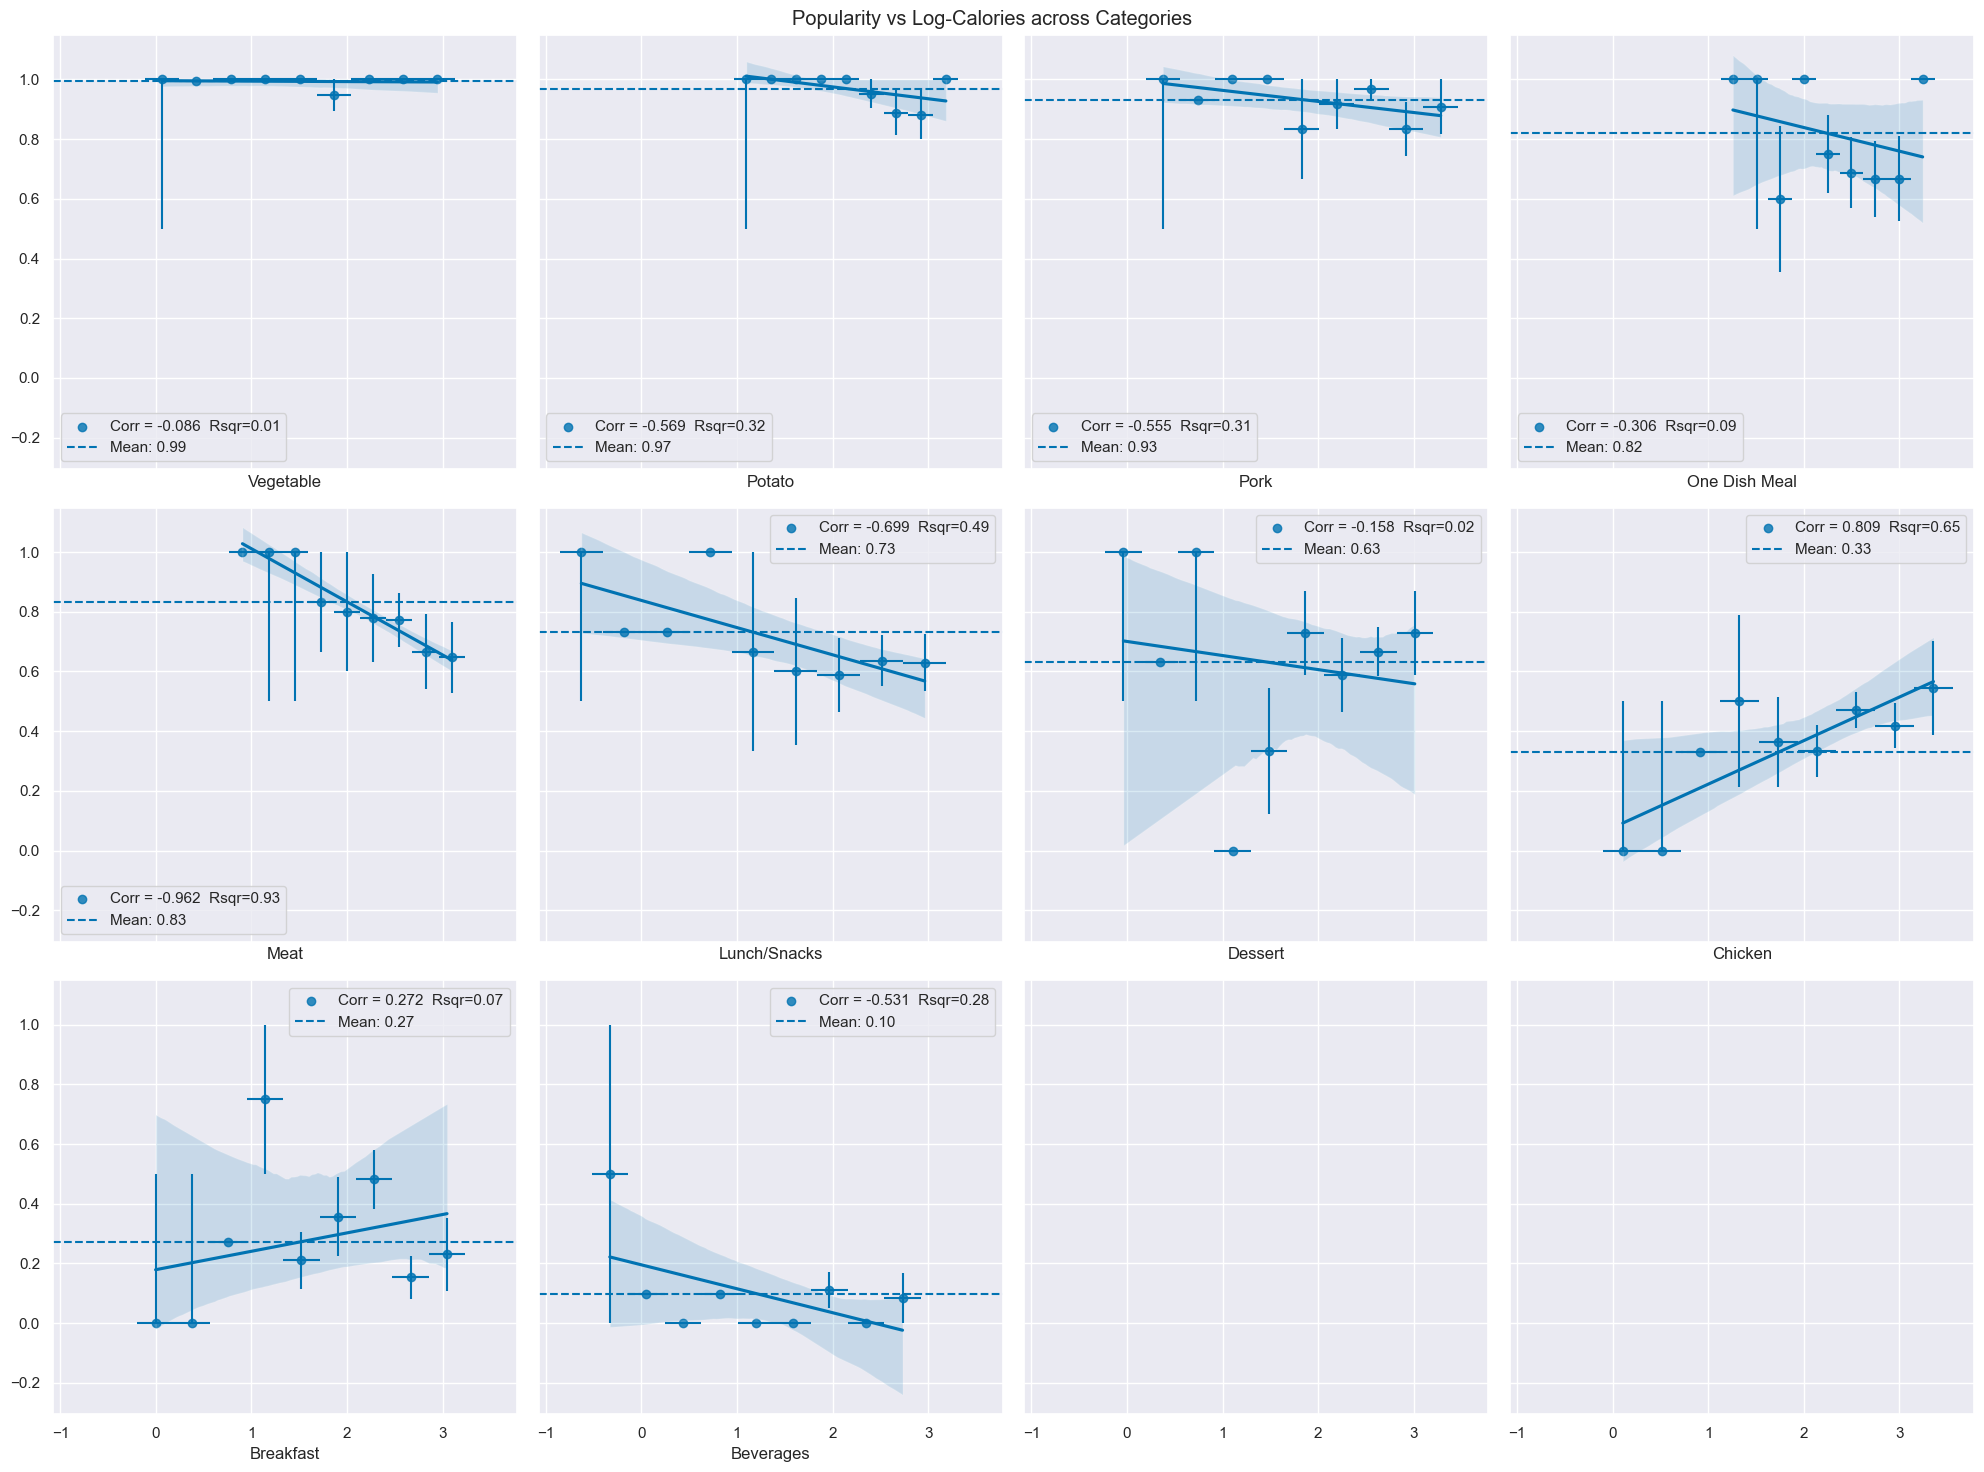

In [27]:

fig, axes = plt.subplots(3,4,figsize=(20,15),sharex=True,sharey=True)
for idx, cat in enumerate(rev_order) :
    mask = recipe_raw['category'] == cat
    bins_cal, props_cal, errs_cal = get_binxs_props_sigmas(recipe_raw[mask],'L_cal')
    corr_coef_cal = np.corrcoef(bins_cal, props_cal)[0,1]

    sns.regplot(x=bins_cal,y=props_cal, ax=axes[idx//4,idx%4], 
                label=f"Corr = {corr_coef_cal:.3F}  Rsqr={corr_coef_cal**2:.2F}").set(xlabel="$\log_{10} calories$")
    axes[idx//4,idx%4].errorbar(x=bins_cal, y=props_cal, yerr=errs_cal, xerr=(bins_cal[1]-bins_cal[0])/2, 
                                ecolor=sns.color_palette()[0],ls='None' )
    axes[idx//4,idx%4].axhline(y=np.mean(props_cal), label=f"Mean: {np.mean(props_cal):.2F}", linestyle='--')

    axes[idx//4,idx%4].legend()
    axes[idx//4,idx%4].set_xlabel(cat)
fig.suptitle('Popularity vs Log-Calories across Categories')
plt.tight_layout()
plt.savefig('calorie_popularity_category.png')
plt.show()

No! In fact, we see a good example of Simpson's paradox in action: an apparent global trend is reversed when broken down across categories. Of the 10 categories, only 2 show a positive correlation with calorie count. In the other 8, popularity actually decreases (or stays the same) as calories increase. 

What's actually happening is that the more popular categories tend to have a higher calorie count. This is shown in the plots, where the mean popularity decreases from category to category, going from most popular (Vegetables) to least popular (Beverages). A higher calorie recipe is more likely to fall within a high-traffic category, but the calorie count itself is not the reason the recipe is popular.

## Exploration Summary

- Single variable plots
The recipe distribution of nutritional values (calories, carbs, sugar, and protein) decays exponentially, so a logarithmic transformation should help for the classification task. The website's recipe list is mostly evenly distributed across each of the categories, except for there being ~2x as many `Chicken` recipes as the other categories.

- Multi-variable plots
The most popular recipes are vegetable recipes, followed by pork recipes and potato recipes. The least popular by far are the beverage recipes. The serving count does not strongly affect the popularity of a recipe. Based on trendlines of binned calorie counts, higher calorie content recipes are correlated with higher popularity recipes. This same trend is observed with protein content. The trend is flipped for sugar content, where low sugar recipes are preferred. However, these trends are not as predictive as one might expect, since these trends do not continue when stratified by category.

# Model Development

We are dealing with a supervised classification problem, so we should be using classifier models. 

A simple classification model is the logistic classifier, which I'll use as the baseline model. 

- Logistic Classifier (baseline)

Then I'll try the alternative model 

- Random Forest Classifier
 
The basic metric we should be looking at is `precision`, since I want to minimize the chance of showing a non-popular article on the homepage. Since precision = TP/PP = 1-FP/PP, maximizing precision also minimizes the false positive rate.

In [28]:
# get rid of the duplicated info (keep the logged nutrition info)
recipe_raw.drop(['calories','carbohydrate','sugar','protein','super'],axis=1,inplace=True)

# also drop recipe id
recipe_raw.drop('recipe',axis=1,inplace=True)

First I'll turn the categories into one-hot encoded feature columns, and drop the target label 'high_traffic' from the feature set. I'll also make sure I haven't leaked label info...

In [29]:
# categorical to numerical through one-hot encoding. Keep all categories so it's easier to interpret, even though dropping the first would still have the same information
recipe_onehot = pd.get_dummies(recipe_raw, prefix_sep='-')
recipe_shuffled = shuffle(recipe_onehot,random_state=2023)

# split into features and labels
X = recipe_shuffled.drop('high_traffic', axis=1)
y = recipe_shuffled['high_traffic']

# split 20% off for testing
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=2023, stratify=y)

X.head()

,servings,nonutri,L_cal,L_carb,L_sug,L_prot,category-Beverages,category-Breakfast,category-Chicken,category-Dessert,category-Lunch/Snacks,category-Meat,category-One Dish Meal,category-Pork,category-Potato,category-Vegetable
857,2,0,2.054268,1.060698,0.238046,1.068186,0,0,0,0,0,0,0,0,0,1
397,2,0,3.312038,0.390935,0.326336,1.843357,0,0,1,0,0,0,0,0,0,0
904,2,0,2.652459,1.982769,0.662758,0.824776,0,0,0,0,0,0,0,1,0,0
112,4,0,2.856741,1.693463,0.086360,0.764923,0,0,0,0,0,0,0,0,1,0
748,4,0,2.357706,1.326131,1.177536,1.924279,0,0,0,0,0,0,0,1,0,0


Looks good.

Next I'll standard-scale the nutritional information so it has mean 0 and standard deviation 1. I'll also min-max scale the (ordinal) serving size to -1 < `servings` < 1 so it has comparable distances to the standard scaling. These scalings should be done entirely based on the training set.

In [30]:
# min/max scale servings to -1 < servings < 1
# and standard scale nutrition information

# training set summary statistics
min_serv, max_serv = X_train['servings'].min(), X_train['servings'].max()

mus, sigmas = {}, {}
for nutri in ['L_cal','L_carb','L_sug','L_prot'] :
    mus[nutri], sigmas[nutri] = X_train[nutri].mean(), X_train[nutri].std()

# scaling both training and test sets based on the summary statistics
for X_set in [X_train, X_test] :
    X_set['servings'] = 2*(X_set['servings']-min_serv)/(max_serv-min_serv) - 1
    
    for nutri in ['L_cal','L_carb','L_sug','L_prot'] :
        X_set[nutri] = (X_set[nutri]-mus[nutri])/sigmas[nutri]

# observe the result of the scaling on each set
print(X_train.iloc[:,:5].describe())
print(X_test.iloc[:,:5].describe())

         servings     nonutri         L_cal        L_carb         L_sug
count  757.000000  757.000000  7.570000e+02  7.570000e+02  7.570000e+02
mean    -0.010832    0.055482 -4.869142e-16 -9.591623e-17  5.631779e-17
std      0.697493    0.229070  1.000000e+00  1.000000e+00  1.000000e+00
min     -1.000000    0.000000 -5.583144e+00 -4.826993e+00 -4.415560e+00
25%     -0.600000    0.000000 -4.781058e-01 -4.915839e-01 -6.047042e-01
50%      0.200000    0.000000  1.373460e-01  1.447952e-01  1.003234e-01
75%      0.200000    0.000000  6.611409e-01  6.594674e-01  6.117646e-01
max      1.000000    1.000000  2.036177e+00  2.323798e+00  2.673322e+00
         servings     nonutri       L_cal      L_carb       L_sug
count  190.000000  190.000000  190.000000  190.000000  190.000000
mean    -0.002105    0.052632   -0.087320    0.034605   -0.023669
std      0.677059    0.223887    0.974605    0.993234    1.029028
min     -1.000000    0.000000   -3.538936   -3.560935   -3.904119
25%     -0.600000    0

## Product Manager's strategy

First I'll look at the precision of the product manager's strategy of simply choosing their favourite recipe. If we model this strategy as a random choice, what is the precision?

In [31]:
np.random.seed(2023)
y_pred_random = np.random.choice([0,1], size=len(y_test))
prec_random = precision_score(y_test,y_pred_random)
print(f"Random Strategy Precision: {prec_random:.2F}")

Random Strategy Precision: 0.62


Looks like the manager's strategy achieves a test precision of ~62%.

## Minimum expectations

Now I'll look at the precision achieved by only and always choosing the 3 most popular categories to be classified as 'high-traffic'.

In [32]:
y_pred_minimum = X_test['category-Vegetable'] + X_test['category-Pork'] + X_test['category-Potato']
prec_minimum = precision_score(y_test,y_pred_minimum)
print(f"Minimum Expectation Precision: {prec_minimum:.3F}")

Minimum Expectation Precision: 0.968


This strategy is very successful, with a test precision of 97%. Is it possible to find a model that does even better?

## Baseline Model

Now I'll evaluate the baseline model (a Logistic Regression Classifier) and look at what it's learned.

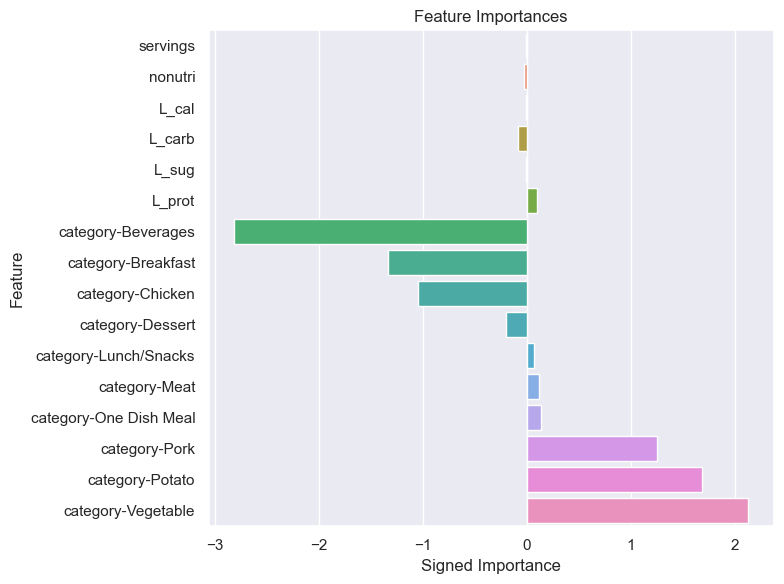

In [33]:
# See how well we do with a simple logistic regression classifier
logreg = LogisticRegression(random_state=2023)

logreg.fit(X_train,y_train)

# Interpret the model's fit
fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x=logreg.coef_[0], y=[x.replace('category_','') for x in X_train.columns], ax=ax)
ax.set_title('Feature Importances')
ax.set_xlabel('Signed Importance')
ax.set_ylabel('Feature')
plt.tight_layout()
plt.savefig('logistic_importance.png')

plt.show()

It looks like it's learned that certain categories are better than others, and that the nutritional information isn't very important at all.

This model will perform differently with respect to precision based on where we set the cutoff threshold for positive prediction probability. The ROC curve will let us see what is possible

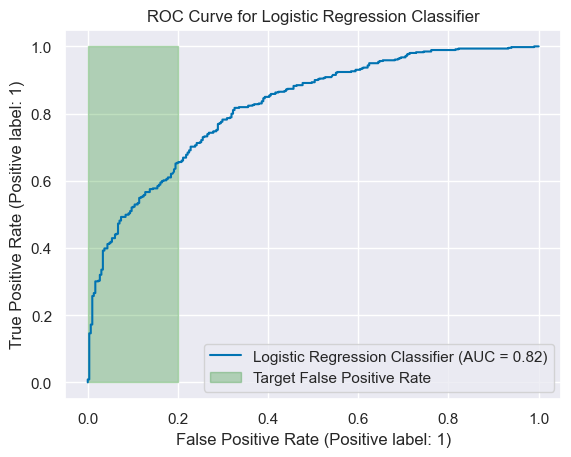

In [34]:
fig, ax = plt.subplots()
plot_roc_curve(logreg, X_train, y_train, name="Logistic Regression Classifier", ax=ax)
ax.set_title('ROC Curve for Logistic Regression Classifier')
plt.fill_between([0,0.2],[0,0],[1,1],alpha=0.25,color='green',label='Target False Positive Rate')
plt.legend()
plt.show()

We see that a false positive rate less than 0.2 (precision of more than 80%) is possible, depending on where the probability threshold is placed. However, this should be balanced against the number of recipes remaining in the 'high-traffic' category (i.e. a precision of 99.9% isn't useful if it only classifies one out of every million recipes as 'high-traffic'). I'll therefore choose an arbitrary target of keeping at least 10% of the recipes as `high-traffic` classifications. From the plot below, it then looks like a good balance between `precision` and `proportion of recipes classified as high-traffic` occurs when the probability threshold is 0.9.

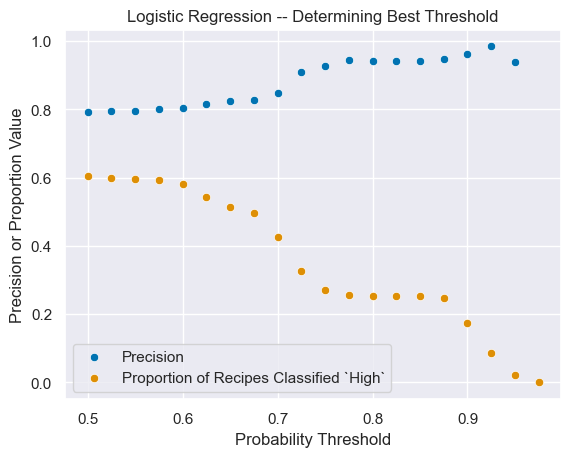

In [35]:
y_trainprob_logreg = logreg.predict_proba(X_train)[:,1]
thresholds = [0.5+0.05*i/2 for i in range(20)]
prec_by_threshold = [ precision_score(y_train,y_trainprob_logreg>threshold) for threshold in thresholds ]
count_by_threshold = [ np.sum(y_trainprob_logreg>threshold)/len(y_train) for threshold in thresholds ]

fig, ax = plt.subplots()
sns.scatterplot(x=thresholds,y=prec_by_threshold, label='Precision')
sns.scatterplot(x=thresholds,y=count_by_threshold, label='Proportion of Recipes Classified `High`')
ax.set_xlabel('Probability Threshold')
ax.set_ylabel('Precision or Proportion Value')
ax.set_title('Logistic Regression -- Determining Best Threshold')
plt.show()

With this criterion (threshold set at 0.9 probability for a 'high-traffic' classification according to the Logistic Regression model), the logistic regression classifier achieves a precision of 97.8% on the test set while still maintaining a high proportion (24%) of high-traffic identifications.

In [36]:
logreg_threshold = 0.9
y_prob_logreg_test=logreg.predict_proba(X_test)[:,1]

prec_logreg_test = precision_score(y_test,y_prob_logreg_test>logreg_threshold)
print(f"Logistic Regression Test Precision: {prec_logreg_test:.3F}")
print(f"Proportion classified as high-traffic: {np.sum(y_prob_logreg_test>logreg_threshold)/len(y_test):.2F}")

Logistic Regression Test Precision: 0.978
Proportion classified as high-traffic: 0.24


This is an even better result than the same evaluation on the training data, which achieves a precision of 96.2% with 17% of the recipes having a `high-traffic` classification.

In [37]:
y_prob_logreg_train=logreg.predict_proba(X_train)[:,1]

prec_logreg_train = precision_score(y_train,y_prob_logreg_train>logreg_threshold)
print(f"Logistic Regression Train Precision: {prec_logreg_train:.3F}")
print(f"Proportion classified as high-traffic: {np.sum(y_prob_logreg_train>logreg_threshold)/len(y_train):.2F}")

Logistic Regression Train Precision: 0.962
Proportion classified as high-traffic: 0.17


## Random Forest Classifier

Now I'll try the Random Forest Classifier, optimizing the hyerparameters through a grid search cross-validation.

### Training

In [38]:
rf = RandomForestClassifier(random_state=42)
rf_grid = {
    'criterion' : ['gini','entropy'],
    'max_depth' : [5,10],
    'max_features' : ['sqrt','log2'],
    'min_samples_leaf' : [5,10,20],
    'min_samples_split' : [5,10],
    'n_estimators' : [40,50,60]
}

In [39]:
# runtime is 50 seconds on my machine
t0 = perf_counter()

search_cv = GridSearchCV(estimator=rf, 
                         param_grid=rf_grid,
                         scoring='roc_auc',
                         cv=5)
search_cv.fit(X_train,y_train)

best_model = search_cv.best_estimator_
best_hypers = search_cv.best_params_
avg_score = search_cv.best_score_

print(f"Best random forest models achieves an average roc_auc_score is {avg_score:.2F} with args {best_hypers}")
t1 = perf_counter()
print(f"Ran in {t1-t0:.1f} seconds")

Best random forest models achieves an average roc_auc_score is 0.80 with args {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 40}
Ran in 48.5 seconds


From the grid search I found that the best hyperparameters are:

- Criterion: entropy
- Max depth: 5
- Max features sampled per Split: sqrt
- Min samples per leaf : 10
- Min samples for a Split: 5
- Number of estimators: 40

### Interpretation

Let's look at how the fitted model is making its choices:

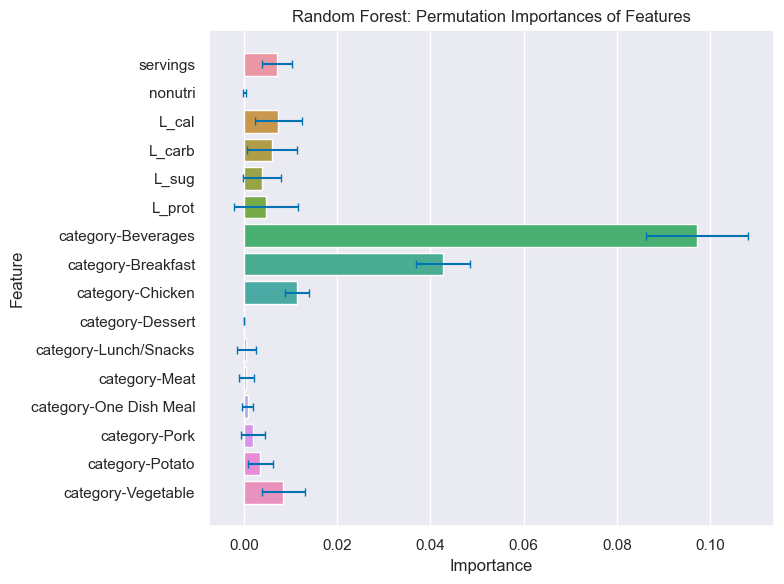

Significant Importances
 -- servings
 -- category-Beverages
 -- category-Breakfast
 -- category-Chicken


In [40]:
# Interpret the model's fit
result = permutation_importance(best_model, X_train, y_train, n_repeats=10, random_state=0)
fig, ax = plt.subplots(figsize=(8,6))
styled_columns = [x.replace('category_','') for x in X_train.columns]
sns.barplot(x=[imp for imp in result.importances_mean], y=styled_columns, ax=ax)
ax.errorbar(x=result.importances_mean, y=styled_columns, xerr=result.importances_std,linestyle='',capsize=3)
ax.set_title('Random Forest: Permutation Importances of Features')
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
plt.tight_layout()

plt.show()

print("Significant Importances")
for idx, (imp, std) in enumerate( zip(result.importances_mean,result.importances_std) ) :
    if np.abs(imp) > 2*std :
        print(f" -- {styled_columns[idx]}")

The random forest isn't as easy to interpret as the Logistic Regression model. From the `permutation importance` approach, it appears to care very strongly about the least popular recipe categories. It moderately cares about the serving size, nutritional information, and the top 3 categories, and doesn't care at all about about the existence of nutrional info, nor the categories with middling popularity. But these learned importances don't really agree with our previous intuition from the Logistic Regression model. So I'll also try a different approach to seeing what the model has learned.

We can try to interpret the model by looking at which training datapoints are classified as 'high traffic'. Using a similar plot from the data exploration section, we can see below that only the top 3 categories are ever predicted to be high traffic. However, we can infer that these 3 categories aren't the only information the model uses, since the classification isn't consistent across an entire category. 

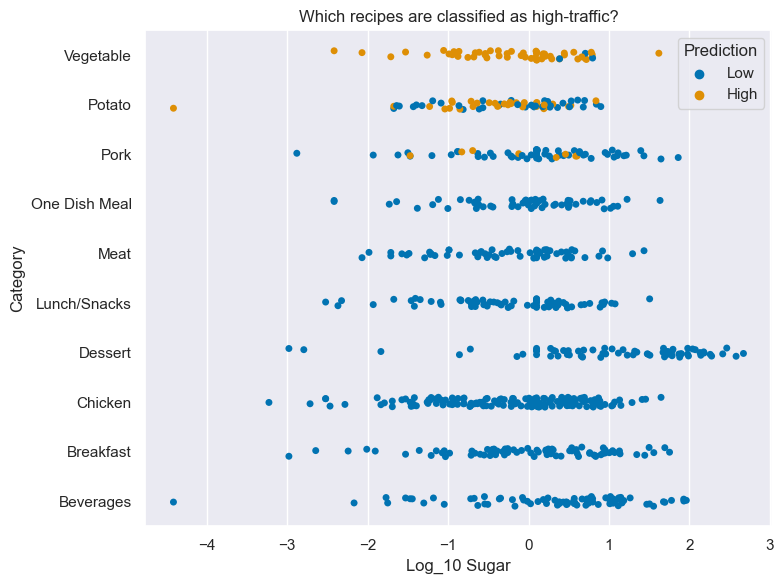

In [41]:
y_trainprob_forest = best_model.predict_proba(X_train)[:,1]

X_interpret=undummify(X_train,prefix_sep="-")
X_interpret['pred'] = y_trainprob_forest>0.83

fig, ax = plt.subplots(figsize=(8,6))
g = sns.stripplot(data=X_interpret,x='L_sug',y='category',hue='pred', order=rev_order, ax=ax)
g.legend_.set_title('Prediction')
new_labels = ['Low', 'High']
for text, label in zip(g.legend_.texts, new_labels):
    text.set_text(label)
plt.savefig('category_calorie_interpret.png')
ax.set_title("Which recipes are classified as high-traffic?")
ax.set_ylabel("Category")
ax.set_xlabel("Log_10 Sugar")
plt.tight_layout()
plt.savefig("interpret_random_forest.png")
plt.show()

Moving away now from interpreting what the model has learned, I'll look at setting the best probability cutoff for the Random Forest's positive identification threshold.

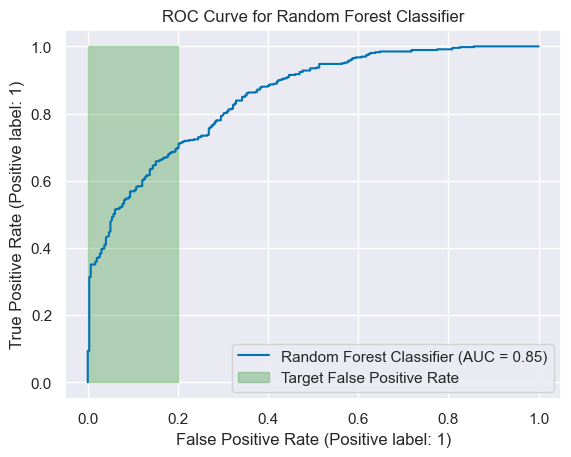

In [42]:
fig, ax = plt.subplots()
plot_roc_curve(best_model, X_train, y_train, name="Random Forest Classifier", ax=ax)
ax.set_title('ROC Curve for Random Forest Classifier')
plt.fill_between([0,0.2],[0,0],[1,1],alpha=0.25,color='green',label='Target False Positive Rate')
plt.legend()
plt.show()

The Area Under the Curve in the ROC plot is slightly better for the Random Forest (0.85) compared to the Logistic Regression (0.82) classifier, so we expect to be able to do slightly better with the precision too. Let's have a look at determining an optimal probability threshold:

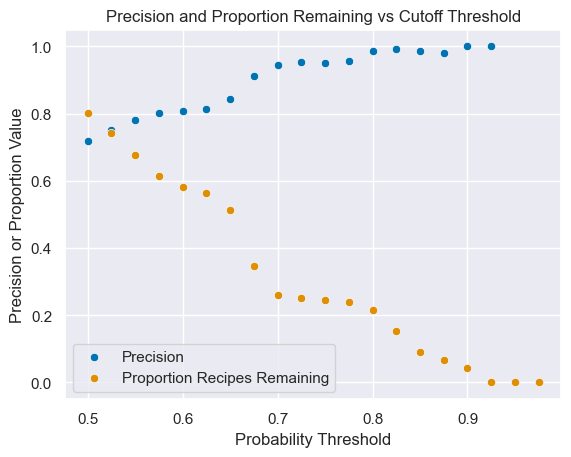

In [43]:
thresholds = [0.5+0.05*i/2 for i in range(20)]
prec_by_threshold = [ precision_score(y_train,y_trainprob_forest>threshold) for threshold in thresholds ]
count_by_threshold = [ np.sum(y_trainprob_forest>threshold)/len(y_train) for threshold in thresholds ]

fig, ax = plt.subplots()
sns.scatterplot(x=thresholds,y=prec_by_threshold, label='Precision')
sns.scatterplot(x=thresholds,y=count_by_threshold, label='Proportion Recipes Remaining')
ax.set_xlabel('Probability Threshold')
ax.set_ylabel('Precision or Proportion Value')
ax.set_title('Precision and Proportion Remaining vs Cutoff Threshold')
plt.show()

A cutoff of 0.83 appears appropriate for the Random Forest model. At this point the precision is 99%, while the proportion of recipes classified as high traffic is still above 10%. 

In [44]:
rf_threshold = 0.83
y_prob_forest_train = best_model.predict_proba(X_train)[:,1]
print(f"Random Forest Train Precision: {precision_score(y_train,y_prob_forest_train>rf_threshold):.3F}")
print(f"Proportion classified as high-traffic: {np.sum(y_prob_forest_train>rf_threshold)/len(y_train):.2F}")

Random Forest Train Precision: 0.990
Proportion classified as high-traffic: 0.13


With this chosen cutoff, the Random Forest Model achieves a precision of 100% on the test set, predicting that 19% of the candidates will be high-traffic recipes.

In [45]:
y_prob_forest_test = best_model.predict_proba(X_test)[:,1]
print(f"Random Forest Test Precision: {precision_score(y_test,y_prob_forest_test>rf_threshold):.3F}")
print(f"Proportion classified as high-traffic: {np.sum(y_prob_forest_test>rf_threshold)/len(y_test):.2F}")

Random Forest Test Precision: 1.000
Proportion classified as high-traffic: 0.19


It would be disingenious to report the model is 100% precise, since the training set was only 99% precise; a more accurate summary statistic is the weighted average of the training and test set precisions, which gives ~99.2% precision. 

              precision    recall  f1-score   support

           0       0.49      1.00      0.66        75
           1       1.00      0.31      0.48       115

    accuracy                           0.58       190
   macro avg       0.74      0.66      0.57       190
weighted avg       0.80      0.58      0.55       190



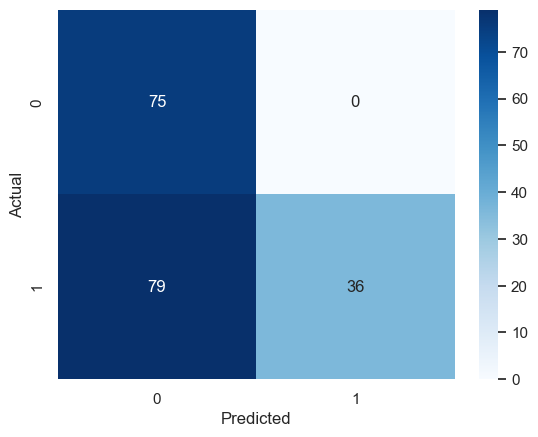

In [46]:
print(classification_report(y_test, y_prob_forest_test>rf_threshold))

cm = confusion_matrix(y_test, y_prob_forest_test>rf_threshold)

fig, ax = plt.subplots()
sns.heatmap(cm, cmap='Blues', annot=True, fmt='d', xticklabels=['0','1'], yticklabels=['0','1'], ax=ax)

ax.set_title('')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.savefig('confusion.png')
plt.show()

# Results

The Logistic Regression model with a tuned probability cutoff scored 97.8% precision in the test set, while the Random Forest, similarly tuned, scored 100%. We will therefore use the **Random Forest** model in production.

### Business Criteria

The Key Performance Indicator (KPI) in this project was the precision of the positive (high-traffic) category. Each model's hyperparameters were tuned for this goal, and thus align very strongly with the business goal. If the model were instead to be tuned for accuracy, or even balanced accuracy, it would perform much worse in terms of precision than the chosen model.

Nevertheless, since the models have been tuned based on the relevant KPI, the goal set out has been achieved. The threshold for success was that a recipe predicted by the model to be 'high-traffic' would have an 80% probability to actually lie in the 'high-traffic' group. Both models exceed this threshold, with the best one attaining ~99.2% precision. This means that, of those it predicts will lead to high traffic on the website, only 0.8% of chosen recipes will fail to meet expectations. 

# Recommendations

The goal has been achieved and the **Random Forest** model can be sent off to the Product Team for use in production.

However, we should continue to monitor the success of the model: since the model only predicts that Vegetables, Pork, and Potatoes will be high-traffic recipes, visitors might get tired from the lack of recipe diversity on the homepage. To take this effect into account, the dataset could be augmented by also measuring the date that a recipe was placed on the homepage. This would allow future models to account for user boredom.